In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:


import diffrax as dfx
import equinox as eqx
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
from jaxtyping import Array, PyTree
from typing import Callable
import matplotlib.pyplot as plt
import jax
import chex


import bioreaction
from bioreaction.simulation.med_sim import *


In [3]:
key = jr.PRNGKey(0)

In [4]:
sp_A = bioreaction.data_containers.Species("A")
sp_B = bioreaction.data_containers.Species("B")

basic_react = bioreaction.data_containers.Reaction( 
    input = [sp_A],  output= [sp_B], forward_rate=1, reverse_rate=1)

example_model = get_int_med_model(bioreaction.data_containers.MedModel( species= [sp_A, sp_B], reactions= [basic_react], 
        other_factors= [], reaction_extrinsics= [], ou_effects= [], impuluses= [], controllers= []))

example_init = MedSimInternelState(concentrations=jnp.ones(2)* 20, other_factors=jnp.array([]) )

example_params = MedSimParams(delta_t= 0.01, t_start=0.0, t_end = 5.0, poisson_sim_reactions=jnp.array([1]), brownian_sim_reaction=jnp.array([0]))



/home/seb/anaconda3/envs/jax/lib/python3.10/site-packages/diffrax/integrate.py:677: UserWarning: `TauLeapingSolutionDependentSolver` is not marked as converging to either the Itô or the Stratonovich solution.
  warnings.warn(


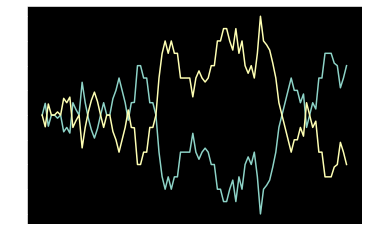

In [5]:
@jax.jit
def sim_ting(rng, init_state):
    return simulate_chunk(rng, example_init, example_model, example_params)

vmapped_sim = jax.jit(jax.vmap(lambda x: sim_ting(x, example_init)))
many_results = vmapped_sim(jr.split(key, 40))
plt.plot(many_results.ys.concentrations[1])

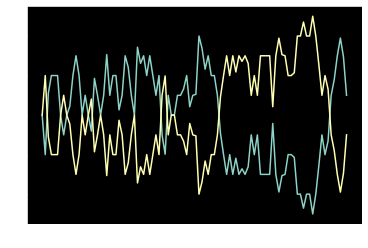

In [6]:
plt.plot(many_results.ys.concentrations[10])

In [7]:
med_model = bioreaction.templates.GeneralMedSim()

int_med_model = get_int_med_model(med_model)
int_med_state = MedSimInternelState(concentrations=jnp.ones(6), other_factors=jnp.zeros(3))

poiss_simmed = jnp.ones(9)
brown_simmed = jnp.zeros(9)

int_med_params = MedSimParams(delta_t= 0.01, t_start=0.0, t_end = 5.0, poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)

In [8]:
get_f_b_rates(int_med_state, int_med_model)[0]

DeviceArray([ 2. ,  5. ,  0.5, 10. ,  0.5,  4. ,  0.1,  1. ,  0.1], dtype=float32)

In [9]:
f_r, b_r = get_f_b_rates(int_med_state, int_med_model)
dt_func = get_dt_func(int_med_model, int_med_params)
brown_func =  get_brown_noise_func(int_med_model, int_med_params)
poiss_func =  get_poisson_func(int_med_model, int_med_params)

In [10]:
func_dict = debug_simulate_chunk(key, int_med_state, int_med_model, int_med_params)

In [11]:
import traceback 
try:
    result_real = simulate_chunk(key, int_med_state, int_med_model, int_med_params)
except:
    traceback.print_exc()

/home/seb/anaconda3/envs/jax/lib/python3.10/site-packages/diffrax/integrate.py:677: UserWarning: `TauLeapingSolutionDependentSolver` is not marked as converging to either the Itô or the Stratonovich solution.
  warnings.warn(


In [16]:
@jax.jit
def sim_ting(rng, init_state):
    return simulate_chunk(rng, init_state, int_med_model, int_med_params)

vmapped_sim = jax.jit(jax.vmap(lambda x: sim_ting(x, int_med_state)))

In [17]:
many_results = vmapped_sim(jr.split(key, 40))

/home/seb/anaconda3/envs/jax/lib/python3.10/site-packages/diffrax/integrate.py:677: UserWarning: `TauLeapingSolutionDependentSolver` is not marked as converging to either the Itô or the Stratonovich solution.
  warnings.warn(


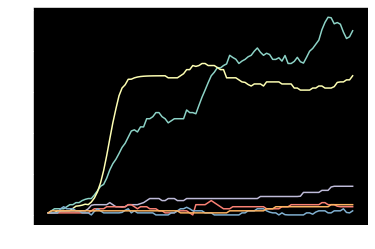

In [22]:
plt.plot(many_results.ys.concentrations[10])

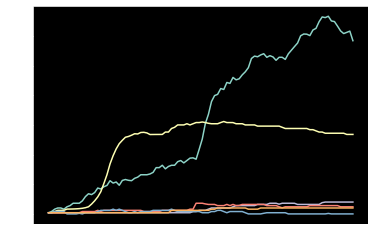

In [19]:
plt.plot(result_real.ys.concentrations)

In [27]:
func_dict["i_t"].vector_field(0, int_med_state, 0)

MedSimInternelState(concentrations=DeviceArray([1., 1., 1., 1., 1., 1.], dtype=float32), other_factors=DeviceArray([0., 0., 0.], dtype=float32))

In [29]:
int_med_params

MedSimParams(delta_t=0.01, t_start=0.0, t_end=5.0, poisson_sim_reactions=DeviceArray([1, 1, 1, 0, 0, 0], dtype=int32), brownian_sim_reaction=DeviceArray([1, 1, 1, 1, 1, 0], dtype=int32))

In [44]:
func_dict["b_p"].evaluate(0,0.01)

MedSimInternelState(concentrations=DeviceArray([-0.08051123,  0.04995818, -0.01033866,  0.03858316,
              0.10834629, -0.1463321 , -0.10046264,  0.14814723,
             -0.02238544], dtype=float32), other_factors=DeviceArray([-0.08575486, -0.08709503, -0.09625503], dtype=float32))

In [50]:
def simulate_chunk_blab(key : jr.PRNGKey, init_state: MedSimInternelState, model: MedSimInternalModel, params: MedSimParams) -> chex.ArrayDevice:
    k1, k2, k3 = jr.split(key, 3)

    dt_func = get_dt_func(model, params)
    time_term = dfx.ODETerm(dt_func)

    brown_func = get_brown_noise_func(model, params)
    brown_tree = get_brown_noise_tree(k1, model, params)
    brown_term = dfx.ControlTerm(brown_func, brown_tree)

    poiss_path = ReactionPoisson(k2, model, params)
    poiss_func = get_poisson_func(model, params)
    poiss_term = dfx.ControlTerm(poiss_func, SolutionDependentControl(poiss_path))

    impulse_term = get_impulse_term(model, params)

    # terms = dfx.MultiTerm(poiss_term, time_term, brown_term, impulse_term)
    terms = time_term

    solver = TauLeapingSolutionDependentSolver(dfx.Euler())
    
    saveat = dfx.SaveAt(ts = jnp.linspace(params.t_start, params.t_end, 100))
    return dfx.diffeqsolve(terms, solver, t0 = params.t_start, t1 = params.t_end, dt0 = params.delta_t, y0=init_state, saveat=saveat)

In [53]:
jnp.sqrt(-1)

DeviceArray(nan, dtype=float32, weak_type=True)

In [51]:
result_help = simulate_chunk_blab(key, int_med_state, int_med_model, int_med_params)

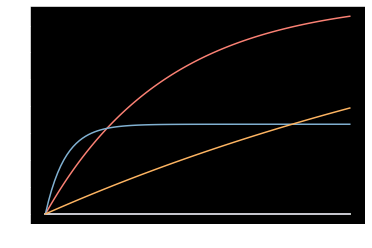

In [52]:
plt.plot(result_help.ys.concentrations)

In [103]:
int_med_state

MedSimInternelState(concentrations=DeviceArray([0., 0., 0., 0., 0., 0.], dtype=float32), other_factors=DeviceArray([0., 0., 0.], dtype=float32))

In [93]:
@chex.dataclass
class StateHolder():
    a : chex.ArrayDevice
    b: chex.ArrayDevice

def basicterm(t,y,args):
    return MedSimInternelState(concentrations = -y.other_factors, other_factors = y.concentrations)


starting_valz = MedSimInternelState(concentrations = 0.0, other_factors = 1.0)

dumb_term = lambda t,y,args : starting_valz

term = dfx.ODETerm(dumb_term)
solver = TauLeapingSolutionDependentSolver(dfx.Euler())

saveat = dfx.SaveAt(ts = jnp.linspace(0,10,100))



solly = dfx.diffeqsolve(term, solver, 0, 10, dt0 = 0.1, y0 = starting_valz, saveat=saveat)

[autoreload of bioreaction.simulation.med_sim failed: Traceback (most recent call last):
  File "/home/seb/anaconda3/envs/jax/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/seb/anaconda3/envs/jax/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/home/seb/anaconda3/envs/jax/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/home/seb/anaconda3/envs/jax/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/home/seb/anaconda3/envs/jax/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
  File "<string>", line 4, in __setattr__
dataclasses.FrozenInstanceError: cannot assign to field '__class__'
]


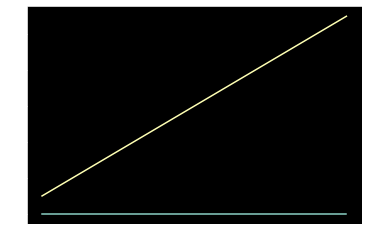

In [87]:
plt.plot(solly.ys.concentrations)
plt.plot(solly.ys.other_factors)